## Settings

In [1]:
# CONTROLS
MODEL_PREFIX = "V17"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.3
MIN_LR = 3e-5 #1e-6
MAX_LR = 1e-3
BATCH_SIZE = 16
PREDICT_BATCH_SIZE = 16
STEP_SIZE = 2
CLR_METHOD = "triangular" # exp_range, triangular, triangular2
NUM_EPOCHS = 10

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

import pickle, os, sys, re, json
from time import time, ctime

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply, MaxPooling1D, Layer, AdditiveAttention, Attention
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy

import tokenizers
import transformers
from transformers import *

%matplotlib inline

In [3]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [4]:
print(ctime(time()))

Wed May 13 20:43:59 2020


In [5]:
print([
    tf.__version__,
    transformers.__version__,
    tokenizers.__version__
])

['2.1.0', '2.8.0', '0.5.2']


## Import Data

In [6]:
df = pd.read_csv("../data/train.csv",
                 encoding="utf8")

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID              text selected_text sentiment
count   27481       27480             27480         27481   
unique  27481       27480             22463         3       
top     8e4c70c9fe  is bored at work  good          neutral 
freq    1           1                 199           11118   


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [7]:
test_df = pd.read_csv("../data/test.csv")
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID  \
count   3534         
unique  3534         
top     11c5c7850b   
freq    1            

                                                                                                                    text  \
count   3534                                                                                                               
unique  3534                                                                                                               
top     Josie`s out of surgery. She`s now officially unable to procreate. And She`s way out of it... Poor medicated baby   
freq    1                                                                                                                  

       sentiment  
count   3534      
unique  3         
top     neutral   
freq    1430      


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [8]:
df.loc[df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [9]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Exploration

#### Sentiment count in training

In [10]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [11]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [12]:
anomalous_idxs = [513, 1060, 5543, 8410, 13605, 24778, 25258] + [18, 27, 32, 39, 48, 49, 64, 66, 84, 92, 102, 116, 129, 132, 134, 149, 160, 166, 168, 189, 196, 197, 210, 223, 247, 251, 260, 285, 295, 296, 297, 309, 349, 362, 366, 382, 396, 398, 406, 410, 425, 458, 460, 482, 492, 500, 504, 517, 533, 537, 543, 569, 573, 581, 604, 605, 608, 634, 636, 637, 639, 642, 665, 670, 674, 678, 685, 702, 707, 709, 710, 727, 737, 746, 751, 757, 768, 778, 787, 794, 804, 809, 853, 854, 856, 863, 871, 872, 912, 931, 937, 942, 950, 956, 957, 963, 992, 993, 999, 1001, 1011, 1012, 1036, 1039, 1057, 1062, 1076, 1077, 1083, 1096, 1105, 1116, 1117, 1122, 1134, 1137, 1150, 1159, 1199, 1200, 1209, 1217, 1264, 1271, 1280, 1283, 1298, 1300, 1303, 1319, 1327, 1342, 1360, 1363, 1365, 1372, 1374, 1376, 1382, 1393, 1416, 1417, 1420, 1447, 1454, 1468, 1472, 1513, 1515, 1518, 1531, 1548, 1558, 1567, 1580, 1588, 1605, 1623, 1648, 1649, 1657, 1659, 1661, 1665, 1672, 1674, 1678, 1683, 1693, 1696, 1713, 1723, 1728, 1739, 1747, 1754, 1798, 1806, 1808, 1814, 1822, 1828, 1830, 1835, 1850, 1857, 1860, 1866, 1888, 1901, 1902, 1929, 1938, 1940, 1987, 1994, 2003, 2004, 2008, 2011, 2023, 2054, 2056, 2065, 2068, 2083, 2086, 2094, 2106, 2113, 2124, 2125, 2136, 2139, 2145, 2168, 2180, 2181, 2187, 2213, 2225, 2227, 2230, 2239, 2273, 2279, 2286, 2288, 2298, 2323, 2324, 2335, 2343, 2359, 2364, 2371, 2385, 2388, 2392, 2398, 2401, 2404, 2410, 2415, 2421, 2430, 2438, 2439, 2440, 2444, 2445, 2448, 2470, 2478, 2489, 2499, 2505, 2515, 2520, 2559, 2574, 2576, 2589, 2598, 2600, 2640, 2643, 2650, 2671, 2679, 2696, 2699, 2706, 2716, 2718, 2731, 2743, 2749, 2750, 2785, 2787, 2789, 2805, 2809, 2825, 2838, 2856, 2888, 2898, 2903, 2923, 2925, 2931, 2933, 2942, 2957, 2961, 2986, 2995, 3034, 3068, 3075, 3077, 3080, 3088, 3089, 3096, 3097, 3101, 3121, 3147, 3160, 3161, 3176, 3182, 3187, 3211, 3225, 3234, 3257, 3263, 3267, 3281, 3290, 3295, 3317, 3319, 3325, 3333, 3359, 3364, 3369, 3374, 3390, 3399, 3400, 3411, 3424, 3473, 3475, 3476, 3479, 3492, 3499, 3504, 3509, 3517, 3519, 3532, 3553, 3578, 3588, 3590, 3593, 3598, 3605, 3606, 3607, 3622, 3634, 3669, 3672, 3678, 3682, 3685, 3694, 3708, 3720, 3729, 3750, 3755, 3784, 3794, 3798, 3801, 3806, 3807, 3813, 3826, 3834, 3872, 3886, 3895, 3903, 3925, 3937, 3946, 3962, 3969, 3998, 4031, 4047, 4053, 4074, 4091, 4093, 4100, 4108, 4113, 4119, 4143, 4148, 4163, 4164, 4183, 4196, 4254, 4260, 4265, 4307, 4308, 4309, 4312, 4318, 4325, 4327, 4328, 4329, 4344, 4347, 4369, 4371, 4377, 4384, 4402, 4404, 4405, 4407, 4412, 4421, 4422, 4437, 4455, 4457, 4471, 4473, 4479, 4483, 4486, 4514, 4532, 4537, 4542, 4543, 4545, 4550, 4554, 4563, 4575, 4576, 4591, 4595, 4631, 4636, 4637, 4639, 4654, 4655, 4704, 4706, 4714, 4718, 4724, 4729, 4735, 4747, 4749, 4750, 4764, 4800, 4814, 4841, 4842, 4844, 4864, 4866, 4869, 4875, 4891, 4908, 4918, 4924, 4928, 4933, 4943, 4946, 4947, 4956, 4968, 4980, 4994, 5009, 5011, 5038, 5056, 5079, 5083, 5101, 5133, 5167, 5173, 5174, 5188, 5189, 5196, 5197, 5213, 5218, 5229, 5241, 5245, 5258, 5279, 5290, 5294, 5297, 5308, 5317, 5331, 5342, 5343, 5353, 5355, 5356, 5358, 5379, 5385, 5386, 5399, 5418, 5433, 5436, 5450, 5456, 5466, 5489, 5504, 5509, 5510, 5530, 5542, 5560, 5583, 5603, 5607, 5618, 5620, 5624, 5626, 5678, 5697, 5712, 5725, 5751, 5757, 5775, 5785, 5799, 5822, 5832, 5836, 5844, 5895, 5902, 5904, 5913, 5918, 5938, 5939, 5961, 5984, 5990, 6025, 6031, 6033, 6060, 6077, 6084, 6090, 6113, 6131, 6134, 6151, 6152, 6176, 6203, 6229, 6230, 6248, 6261, 6277, 6289, 6296, 6304, 6308, 6317, 6319, 6321, 6335, 6338, 6343, 6353, 6356, 6360, 6377, 6382, 6395, 6404, 6425, 6433, 6468, 6474, 6475, 6476, 6477, 6510, 6528, 6540, 6574, 6580, 6582, 6593, 6609, 6627, 6628, 6633, 6635, 6650, 6656, 6657, 6670, 6673, 6676, 6677, 6679, 6686, 6702, 6724, 6740, 6745, 6759, 6801, 6804, 6830, 6833, 6834, 6842, 6859, 6871, 6875, 6878, 6880, 6885, 6896, 6934, 6939, 6948, 6950, 6958, 6970, 6979, 6987, 7010, 7017, 7024, 7040, 7099, 7107, 7112, 7136, 7147, 7149, 7158, 7184, 7225, 7227, 7251, 7274, 7288, 7305, 7306, 7308, 7331, 7344, 7355, 7373, 7407, 7408, 7409, 7410, 7423, 7436, 7438, 7442, 7444, 7450, 7469, 7473, 7479, 7487, 7492, 7506, 7513, 7521, 7528, 7530, 7546, 7567, 7581, 7582, 7597, 7599, 7602, 7632, 7635, 7636, 7642, 7662, 7663, 7701, 7752, 7758, 7765, 7769, 7778, 7780, 7788, 7801, 7816, 7818, 7831, 7836, 7837, 7849, 7893, 7895, 7896, 7922, 7927, 7945, 7948, 7968, 7997, 8003, 8005, 8010, 8030, 8049, 8051, 8052, 8059, 8060, 8085, 8094, 8142, 8143, 8151, 8153, 8161, 8169, 8170, 8196, 8208, 8212, 8215, 8224, 8235, 8241, 8249, 8250, 8276, 8282, 8285, 8286, 8288, 8289, 8299, 8314, 8338, 8343, 8345, 8349, 8373, 8379, 8390, 8397, 8399, 8407, 8427, 8428, 8432, 8439, 8442, 8444, 8484, 8493, 8497, 8500, 8507, 8510, 8534, 8546, 8559, 8569, 8579, 8588, 8594, 8604, 8617, 8620, 8624, 8631, 8638, 8661, 8671, 8674, 8687, 8691, 8696, 8706, 8720, 8729, 8749, 8756, 8758, 8769, 8774, 8780, 8800, 8803, 8809, 8815, 8827, 8830, 8875, 8902, 8906, 8910, 8917, 8919, 8922, 8951, 8954, 8968, 8985, 8986, 8991, 8999, 9014, 9034, 9050, 9057, 9063, 9070, 9088, 9098, 9112, 9113, 9122, 9127, 9140, 9155, 9157, 9169, 9179, 9190, 9216, 9223, 9226, 9264, 9272, 9281, 9297, 9300, 9303, 9322, 9354, 9361, 9374, 9377, 9381, 9385, 9400, 9403, 9419, 9422, 9425, 9428, 9436, 9442, 9449, 9454, 9456, 9458, 9470, 9482, 9496, 9500, 9535, 9539, 9541, 9554, 9556, 9560, 9565, 9574, 9594, 9605, 9610, 9631, 9632, 9660, 9689, 9691, 9696, 9708, 9710, 9712, 9725, 9726, 9734, 9742, 9753, 9770, 9789, 9799, 9801, 9812, 9817, 9836, 9839, 9850, 9852, 9881, 9882, 9891, 9906, 9912, 9920, 9922, 9928, 9976, 9980, 9984, 10002, 10004, 10007, 10029, 10039, 10042, 10050, 10052, 10057, 10067, 10070, 10092, 10093, 10123, 10131, 10138, 10145, 10151, 10164, 10167, 10170, 10179, 10184, 10185, 10190, 10197, 10200, 10211, 10218, 10219, 10222, 10228, 10245, 10247, 10255, 10259, 10276, 10293, 10298, 10299, 10306, 10319, 10327, 10342, 10348, 10377, 10379, 10449, 10465, 10469, 10492, 10504, 10505, 10508, 10521, 10528, 10529, 10530, 10570, 10573, 10577, 10578, 10597, 10611, 10639, 10651, 10666, 10672, 10675, 10690, 10706, 10711, 10738, 10742, 10747, 10749, 10779, 10782, 10783, 10795, 10813, 10849, 10852, 10853, 10884, 10885, 10888, 10892, 10901, 10914, 10918, 10919, 10933, 10935, 10956, 10966, 10968, 10970, 10981, 10986, 10996, 10999, 11005, 11032, 11038, 11051, 11055, 11060, 11067, 11097, 11102, 11155, 11157, 11159, 11162, 11167, 11176, 11187, 11215, 11222, 11228, 11230, 11257, 11263, 11265, 11274, 11286, 11289, 11297, 11300, 11308, 11323, 11337, 11339, 11341, 11347, 11349, 11353, 11371, 11381, 11386, 11426, 11431, 11448, 11449, 11474, 11480, 11500, 11507, 11553, 11562, 11582, 11588, 11594, 11612, 11616, 11618, 11636, 11643, 11650, 11658, 11666, 11679, 11683, 11693, 11695, 11698, 11699, 11706, 11716, 11723, 11730, 11732, 11741, 11745, 11780, 11794, 11798, 11808, 11812, 11828, 11829, 11837, 11840, 11841, 11844, 11849, 11853, 11854, 11855, 11861, 11862, 11872, 11875, 11878, 11886, 11890, 11899, 11905, 11912, 11938, 11963, 11967, 11973, 11980, 11985, 11999, 12026, 12027, 12029, 12039, 12054, 12067, 12115, 12124, 12134, 12136, 12138, 12150, 12187, 12205, 12206, 12224, 12242, 12258, 12269, 12277, 12283, 12295, 12305, 12314, 12322, 12331, 12333, 12334, 12350, 12355, 12356, 12360, 12370, 12372, 12389, 12395, 12396, 12397, 12405, 12410, 12416, 12429, 12439, 12440, 12442, 12446, 12474, 12482, 12486, 12507, 12516, 12521, 12522, 12526, 12527, 12537, 12550, 12563, 12576, 12585, 12586, 12587, 12598, 12606, 12630, 12631, 12635, 12639, 12650, 12657, 12662, 12669, 12687, 12703, 12718, 12724, 12732, 12736, 12745, 12767, 12787, 12803, 12804, 12808, 12818, 12830, 12843, 12855, 12856, 12870, 12884, 12903, 12914, 12920, 12923, 12924, 12927, 12936, 12972, 12977, 12998, 13003, 13004, 13009, 13044, 13068, 13069, 13074, 13080, 13095, 13098, 13124, 13130, 13153, 13154, 13176, 13219, 13222, 13227, 13237, 13267, 13274, 13293, 13301, 13304, 13307, 13330, 13333, 13354, 13365, 13373, 13379, 13381, 13389, 13397, 13422, 13430, 13433, 13445, 13466, 13473, 13476, 13482, 13490, 13493, 13528, 13529, 13535, 13543, 13558, 13559, 13586, 13637, 13643, 13646, 13665, 13674, 13678, 13679, 13704, 13707, 13710, 13718, 13727, 13733, 13747, 13762, 13772, 13785, 13796, 13803, 13812, 13814, 13817, 13827, 13844, 13846, 13847, 13848, 13854, 13855, 13861, 13864, 13873, 13899, 13907, 13936, 13939, 13946, 13949, 13954, 13964, 13965, 13974, 13975, 13978, 13980, 14002, 14006, 14007, 14030, 14043, 14044, 14057, 14058, 14060, 14073, 14091, 14109, 14110, 14112, 14117, 14131, 14132, 14159, 14172, 14173, 14176, 14184, 14194, 14197, 14200, 14204, 14207, 14213, 14230, 14257, 14273, 14275, 14287, 14299, 14301, 14307, 14308, 14347, 14362, 14365, 14381, 14386, 14400, 14416, 14428, 14436, 14446, 14457, 14458, 14462, 14487, 14499, 14509, 14532, 14548, 14551, 14571, 14596, 14598, 14611, 14621, 14639, 14640, 14648, 14662, 14669, 14671, 14676, 14680, 14687, 14689, 14691, 14718, 14731, 14747, 14779, 14787, 14825, 14839, 14844, 14847, 14855, 14870, 14880, 14891, 14908, 14946, 14959, 14960, 14967, 14971, 14986, 15007, 15010, 15016, 15044, 15049, 15055, 15056, 15112, 15131, 15158, 15165, 15174, 15177, 15196, 15203, 15206, 15207, 15213, 15217, 15233, 15236, 15253, 15259, 15286, 15296, 15307, 15308, 15321, 15323, 15327, 15339, 15363, 15372, 15374, 15379, 15380, 15383, 15385, 15392, 15410, 15449, 15452, 15462, 15464, 15465, 15477, 15483, 15503, 15505, 15528, 15532, 15548, 15562, 15566, 15571, 15605, 15610, 15622, 15651, 15660, 15666, 15674, 15709, 15721, 15731, 15735, 15736, 15741, 15767, 15774, 15785, 15792, 15793, 15811, 15851, 15879, 15883, 15884, 15912, 15926, 15927, 15931, 15940, 15959, 15965, 15985, 15998, 16020, 16027, 16031, 16032, 16044, 16070, 16100, 16117, 16129, 16136, 16137, 16140, 16149, 16152, 16175, 16186, 16201, 16241, 16261, 16269, 16272, 16279, 16290, 16308, 16319, 16324, 16325, 16327, 16338, 16341, 16345, 16352, 16354, 16371, 16372, 16385, 16391, 16416, 16423, 16448, 16455, 16468, 16470, 16477, 16481, 16484, 16491, 16493, 16500, 16509, 16510, 16516, 16541, 16559, 16577, 16589, 16632, 16638, 16642, 16643, 16649, 16650, 16654, 16665, 16677, 16684, 16704, 16720, 16726, 16734, 16765, 16774, 16775, 16777, 16780, 16797, 16798, 16799, 16803, 16807, 16809, 16830, 16832, 16861, 16863, 16868, 16876, 16889, 16890, 16902, 16915, 16927, 16939, 16949, 16962, 16968, 17002, 17010, 17013, 17021, 17023, 17029, 17062, 17066, 17084, 17093, 17094, 17102, 17152, 17160, 17167, 17173, 17183, 17221, 17239, 17250, 17267, 17277, 17278, 17282, 17296, 17307, 17315, 17333, 17336, 17344, 17346, 17348, 17354, 17365, 17374, 17385, 17387, 17397, 17401, 17404, 17412, 17417, 17432, 17436, 17444, 17452, 17467, 17469, 17501, 17502, 17513, 17530, 17531, 17547, 17550, 17555, 17573, 17577, 17578, 17586, 17600, 17602, 17611, 17627, 17640, 17645, 17648, 17649, 17652, 17667, 17676, 17682, 17721, 17724, 17729, 17731, 17751, 17754, 17762, 17770, 17772, 17781, 17802, 17820, 17823, 17833, 17848, 17857, 17858, 17865, 17867, 17887, 17893, 17909, 17924, 17926, 17945, 17971, 17977, 17986, 17990, 18003, 18011, 18042, 18046, 18052, 18077, 18086, 18091, 18099, 18103, 18123, 18128, 18131, 18142, 18153, 18165, 18167, 18173, 18181, 18206, 18226, 18252, 18263, 18276, 18277, 18284, 18314, 18319, 18327, 18330, 18342, 18352, 18355, 18362, 18364, 18375, 18383, 18398, 18403, 18432, 18447, 18453, 18465, 18467, 18485, 18486, 18492, 18505, 18508, 18510, 18515, 18536, 18540, 18548, 18550, 18557, 18563, 18570, 18574, 18576, 18616, 18622, 18627, 18639, 18649, 18655, 18673, 18681, 18712, 18745, 18746, 18758, 18773, 18778, 18782, 18826, 18832, 18834, 18842, 18851, 18853, 18858, 18862, 18867, 18872, 18877, 18908, 18910, 18912, 18913, 18919, 18925, 18929, 18930, 18933, 18936, 18944, 18974, 18975, 18997, 19009, 19011, 19014, 19016, 19028, 19057, 19098, 19106, 19114, 19130, 19133, 19147, 19157, 19162, 19166, 19173, 19179, 19198, 19213, 19225, 19230, 19239, 19241, 19266, 19274, 19279, 19283, 19285, 19316, 19327, 19335, 19352, 19358, 19362, 19366, 19377, 19379, 19405, 19423, 19428, 19431, 19437, 19444, 19456, 19469, 19475, 19476, 19481, 19486, 19492, 19506, 19507, 19536, 19537, 19562, 19586, 19589, 19622, 19634, 19651, 19663, 19679, 19685, 19690, 19697, 19707, 19712, 19714, 19715, 19717, 19724, 19734, 19744, 19754, 19769, 19779, 19792, 19807, 19830, 19850, 19863, 19875, 19903, 19904, 19908, 19963, 19985, 19988, 20003, 20012, 20014, 20018, 20040, 20042, 20054, 20078, 20079, 20083, 20087, 20089, 20114, 20121, 20122, 20138, 20155, 20162, 20186, 20199, 20216, 20222, 20234, 20238, 20254, 20285, 20299, 20302, 20305, 20337, 20345, 20364, 20365, 20374, 20382, 20394, 20403, 20440, 20450, 20451, 20476, 20506, 20508, 20516, 20527, 20536, 20540, 20541, 20542, 20557, 20566, 20584, 20608, 20611, 20613, 20618, 20627, 20644, 20656, 20663, 20674, 20682, 20690, 20699, 20707, 20711, 20737, 20751, 20765, 20771, 20774, 20778, 20779, 20789, 20795, 20798, 20834, 20851, 20865, 20867, 20869, 20872, 20883, 20892, 20894, 20895, 20896, 20901, 20919, 20924, 20933, 20937, 20938, 20946, 20947, 20955, 20957, 20958, 20965, 20966, 20970, 20974, 20991, 21001, 21013, 21018, 21020, 21025, 21114, 21142, 21205, 21210, 21227, 21230, 21236, 21253, 21262, 21294, 21300, 21316, 21331, 21339, 21349, 21356, 21365, 21369, 21376, 21399, 21410, 21413, 21418, 21420, 21435, 21447, 21452, 21455, 21468, 21470, 21474, 21486, 21495, 21501, 21517, 21530, 21539, 21546, 21547, 21553, 21556, 21564, 21569, 21579, 21593, 21595, 21599, 21603, 21632, 21643, 21690, 21713, 21726, 21732, 21737, 21738, 21744, 21755, 21773, 21782, 21800, 21807, 21829, 21839, 21848, 21876, 21893, 21923, 21926, 21931, 21958, 21967, 21970, 21973, 21982, 22002, 22029, 22031, 22035, 22044, 22051, 22068, 22073, 22099, 22117, 22121, 22126, 22145, 22146, 22149, 22161, 22166, 22170, 22177, 22205, 22210, 22231, 22233, 22234, 22244, 22246, 22251, 22272, 22280, 22299, 22317, 22321, 22327, 22350, 22355, 22363, 22365, 22378, 22383, 22387, 22391, 22393, 22395, 22403, 22406, 22418, 22423, 22428, 22437, 22444, 22451, 22453, 22460, 22480, 22491, 22510, 22530, 22536, 22554, 22557, 22561, 22562, 22564, 22571, 22588, 22593, 22606, 22607, 22610, 22611, 22642, 22666, 22717, 22729, 22738, 22744, 22745, 22763, 22768, 22769, 22774, 22782, 22789, 22796, 22800, 22836, 22841, 22843, 22858, 22864, 22886, 22889, 22897, 22925, 22928, 22938, 22944, 22945, 22948, 22950, 22956, 22983, 22986, 22988, 22993, 22994, 22997, 23028, 23030, 23039, 23047, 23081, 23091, 23097, 23105, 23108, 23111, 23113, 23133, 23145, 23150, 23161, 23172, 23176, 23199, 23200, 23202, 23204, 23205, 23211, 23212, 23226, 23227, 23231, 23236, 23239, 23263, 23265, 23266, 23269, 23290, 23311, 23315, 23320, 23323, 23340, 23352, 23361, 23372, 23375, 23376, 23381, 23386, 23390, 23401, 23415, 23418, 23428, 23429, 23453, 23467, 23479, 23505, 23508, 23527, 23528, 23535, 23537, 23541, 23553, 23555, 23557, 23559, 23563, 23566, 23581, 23585, 23596, 23598, 23604, 23605, 23617, 23630, 23643, 23658, 23669, 23673, 23680, 23683, 23690, 23691, 23701, 23707, 23714, 23720, 23725, 23733, 23746, 23750, 23751, 23769, 23774, 23784, 23809, 23818, 23831, 23839, 23842, 23857, 23924, 23930, 23944, 23945, 23947, 23959, 23971, 23975, 23987, 23989, 24002, 24003, 24009, 24019, 24026, 24039, 24041, 24046, 24062, 24071, 24077, 24079, 24087, 24096, 24119, 24121, 24137, 24150, 24169, 24181, 24194, 24195, 24199, 24200, 24203, 24210, 24223, 24258, 24272, 24274, 24291, 24293, 24300, 24305, 24318, 24339, 24378, 24380, 24383, 24392, 24402, 24442, 24468, 24476, 24480, 24488, 24490, 24495, 24502, 24504, 24505, 24516, 24562, 24572, 24594, 24595, 24597, 24600, 24606, 24609, 24622, 24623, 24629, 24631, 24632, 24633, 24657, 24662, 24664, 24666, 24682, 24697, 24709, 24753, 24758, 24766, 24833, 24840, 24851, 24858, 24869, 24886, 24909, 24915, 24916, 24929, 24945, 24951, 24966, 24972, 24980, 24996, 25012, 25017, 25043, 25059, 25067, 25104, 25121, 25125, 25127, 25133, 25150, 25191, 25210, 25224, 25228, 25240, 25243, 25255, 25264, 25267, 25272, 25282, 25284, 25290, 25292, 25293, 25334, 25338, 25350, 25365, 25368, 25380, 25389, 25391, 25400, 25413, 25422, 25440, 25444, 25446, 25456, 25460, 25472, 25486, 25495, 25499, 25509, 25512, 25528, 25530, 25532, 25547, 25559, 25591, 25593, 25597, 25601, 25614, 25616, 25638, 25672, 25691, 25698, 25712, 25713, 25721, 25722, 25725, 25732, 25753, 25760, 25775, 25794, 25813, 25819, 25828, 25833, 25901, 25908, 25947, 25983, 25987, 25989, 25996, 26008, 26017, 26025, 26030, 26039, 26047, 26054, 26058, 26077, 26088, 26092, 26112, 26183, 26185, 26190, 26201, 26204, 26237, 26239, 26241, 26248, 26251, 26252, 26256, 26263, 26268, 26282, 26314, 26331, 26346, 26358, 26360, 26364, 26377, 26428, 26434, 26460, 26481, 26485, 26497, 26532, 26533, 26538, 26561, 26567, 26585, 26588, 26595, 26596, 26618, 26625, 26633, 26643, 26651, 26677, 26687, 26715, 26721, 26732, 26733, 26746, 26760, 26762, 26769, 26779, 26781, 26822, 26828, 26830, 26870, 26882, 26883, 26889, 26892, 26894, 26914, 26927, 26932, 26944, 26953, 26957, 26963, 26967, 26973, 26976, 26978, 26985, 27030, 27038, 27044, 27048, 27052, 27067, 27111, 27115, 27121, 27142, 27144, 27153, 27167, 27205, 27209, 27217, 27218, 27229, 27233, 27240, 27250, 27280, 27302, 27332, 27339, 27349, 27362, 27376, 27386, 27396, 27401, 27413, 27426, 27429, 27456, 27470, 27474, 27476, 27477, 27480]

In [13]:
print(df.shape)
df = df[(~df.index.isin(anomalous_idxs))]
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 5)
(24857, 5)
(24856, 5)


In [14]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [15]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

In [16]:
df["text_mod"] = "<s> " + df.text.str.strip() + " </s> " + df.sentiment + " </s>"
test_df["text_mod"] = "<s> " + test_df.text.str.strip() + " </s> " + test_df.sentiment + " </s>"

#### Random Shuffle and Train Val Indices

In [17]:
n_rows = df.shape[0]
idx = [i for i in np.arange(n_rows)]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO * n_rows)], idx[round(TRAIN_SPLIT_RATIO * n_rows):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

24856 19885 4971 24856


In [18]:
df["set_name"] = np.where(df.index.isin(val_idx), "val", "train")

In [19]:
df.groupby("set_name")["textID"].count()

set_name
train    19885
val      4971 
Name: textID, dtype: int64

#### Tokenization

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [21]:
tokenizer.save_pretrained("../results/tokenizers/roberta_tokenizer/")

('../results/tokenizers/roberta_tokenizer/vocab.json',
 '../results/tokenizers/roberta_tokenizer/merges.txt',
 '../results/tokenizers/roberta_tokenizer/special_tokens_map.json',
 '../results/tokenizers/roberta_tokenizer/added_tokens.json')

In [22]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file="../results/tokenizers/roberta_tokenizer/vocab.json",
    merges_file="../results/tokenizers/roberta_tokenizer/merges.txt",
    add_prefix_space=True,
    lowercase=True)

In [23]:
with open("../results/tokenizers/roberta_tokenizer/special_tokens_map.json") as f:
    special_tokens = json.load(f)

tokenizer.add_special_tokens([i for i in special_tokens.values()])

0

In [24]:
X_tokens = tokenizer.encode_batch(df.text_mod.tolist())
Y_tokens = tokenizer.encode_batch(df.selected_text.tolist())
X_tokens_test = tokenizer.encode_batch(test_df.text_mod.tolist())

In [25]:
X = [i.ids for i in X_tokens]
Y = [i.ids for i in Y_tokens]
X_test = [i.ids for i in X_tokens_test]

In [26]:
X_att = [i.attention_mask for i in X_tokens]
Y_att = [i.attention_mask for i in Y_tokens]
X_att_test = [i.attention_mask for i in X_tokens_test]

In [27]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = tokenizer.get_vocab_size()
print(VOCAB_SIZE, max_len)

50265 106


In [28]:
def get_extremities(l_string, s_string, print_it=False):
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = [0] * len_l, [0] * len_l
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (start_vector, end_vector)

In [29]:
Y_starts, Y_stops = [], []
anomaly_idx, counter = [], 0
for num, (i,j) in enumerate(zip(X_tokens, Y_tokens)):
    x,y = i.ids, j.ids
    #s,e = get_extremities(x, y)
    try:
        s,e = get_extremities(x, y)
    except TypeError as t:
        counter += 1
        anomaly_idx.append(num)
    Y_starts.append(s)
    Y_stops.append(e)
print(num + 1, "\t: #Processed")

print(counter,"\t: # of Anomalies")

24856 	: #Processed
0 	: # of Anomalies


In [30]:
if counter:
    print(anomaly_idx, sep=",")
    print(df["original_index"].iloc[anomaly_idx].tolist())
    df.iloc[anomaly_idx].tail(10)

In [31]:
check_idx = 156
print(df.text[check_idx])
print(df.selected_text[check_idx])
print([[i,j,k,l] for i,j,k,l in zip(X_tokens[check_idx].tokens,
                                    X_tokens[check_idx].ids,
                                    Y_starts[check_idx],
                                    Y_stops[check_idx])])
print([[i,j] for i,j in zip(Y_tokens[check_idx].ids,
                            Y_tokens[check_idx].tokens)])

or even NOOOOO NOT THE SECRET NAMEREBECCA PLEASE
NOT THE SECRET NAMEREBECCA PLEASE
[['<s>', 0, 0, 0], ['Ġor', 50, 0, 0], ['Ġeven', 190, 0, 0], ['Ġno', 117, 0, 0], ['oooo', 40386, 0, 0], ['Ġnot', 45, 1, 0], ['Ġthe', 5, 0, 0], ['Ġsecret', 3556, 0, 0], ['Ġname', 766, 0, 0], ['re', 241, 0, 0], ['becca', 39746, 0, 0], ['Ġplease', 2540, 0, 1], ['Ġ', 1437, 0, 0], ['</s>', 2, 0, 0], ['Ġnegative', 2430, 0, 0], ['Ġ', 1437, 0, 0], ['</s>', 2, 0, 0]]
[[45, 'Ġnot'], [5, 'Ġthe'], [3556, 'Ġsecret'], [766, 'Ġname'], [241, 're'], [39746, 'becca'], [2540, 'Ġplease']]


#### Train Validation  split

In [32]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 19885 	 : X_train 
 19885 	 : X_att_train 
 19885 	 : Y_train 
 19885 	 : Y_starts_train 
 19885 	 : Y_stops_train 
 4971 	 : X_val 
 4971 	 : X_att_val 
 4971 	 : Y_val 
 4971 	 : Y_starts_val 
 4971 	 : Y_stops_val 



#### Padding

In [33]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [34]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (19885, 106) 	: X_train  
 (19885, 106) 	: X_att_train  
 (19885, 106) 	: Y_train  
 (19885, 106) 	: Y_starts_train  
 (19885, 106) 	: Y_stops_train  
 (4971, 106) 	: X_val  
 (4971, 106) 	: X_att_val  
 (4971, 106) 	: Y_val  
 (4971, 106) 	: Y_starts_val  
 (4971, 106) 	: Y_stops_val  
 (3534, 106) 	: X_test  
 (3534, 106) 	: X_att_test  



#### Check inputs and outputs

In [35]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[0, 1, 885, 0, 0],
 [31095, 1, 41407, 0, 0],
 [6, 1, 0, 0, 0],
 [13, 1, 0, 0, 0],
 [769, 1, 0, 0, 0],
 [1536, 1, 0, 0, 0],
 [116, 1, 0, 0, 0],
 [885, 1, 0, 1, 0],
 [41407, 1, 0, 0, 1],
 [1437, 1, 0, 0, 0],
 [2, 1, 0, 0, 0],
 [2430, 1, 0, 0, 0],
 [1437, 1, 0, 0, 0],
 [2, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0,

In [36]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[0, 1, 141, 0, 0],
 [25245, 1, 7735, 0, 0],
 [7, 1, 16, 0, 0],
 [475, 1, 79, 0, 0],
 [11000, 1, 116, 0, 0],
 [8, 1, 20635, 0, 0],
 [741, 1, 45, 0, 0],
 [5556, 1, 98, 0, 0],
 [23611, 1, 203, 0, 0],
 [8084, 1, 5988, 0, 0],
 [4, 1, 4, 0, 0],
 [141, 1, 0, 1, 0],
 [7735, 1, 0, 0, 0],
 [16, 1, 0, 0, 0],
 [79, 1, 0, 0, 0],
 [116, 1, 0, 0, 0],
 [20635, 1, 0, 0, 0],
 [45, 1, 0, 0, 0],
 [98, 1, 0, 0, 0],
 [203, 1, 0, 0, 0],
 [5988, 1, 0, 0, 0],
 [4, 1, 0, 0, 1],
 [1437, 1, 0, 0, 0],
 [2, 1, 0, 0, 0],
 [2430, 1, 0, 0, 0],
 [1437, 1, 0, 0, 0],
 [2, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 

In [37]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_tokens_test[num].ids,
                          X_test[num],
                          X_tokens_test[num].attention_mask)]

[[0, 0, 1],
 [1021, 1021, 1],
 [139, 139, 1],
 [2678, 2678, 1],
 [6, 6, 1],
 [15049, 15049, 1],
 [328, 328, 1],
 [10, 10, 1],
 [9202, 9202, 1],
 [9, 9, 1],
 [15049, 15049, 1],
 [328, 328, 1],
 [8, 8, 1],
 [24, 24, 1],
 [40, 40, 1],
 [28, 28, 1],
 [1613, 1613, 1],
 [30, 30, 1],
 [5, 5, 1],
 [86, 86, 1],
 [939, 939, 1],
 [989, 989, 1],
 [173, 173, 1],
 [8, 8, 1],
 [4209, 4209, 1],
 [19, 19, 1],
 [1895, 1895, 1],
 [4, 4, 1],
 [1437, 1437, 1],
 [1589, 1589, 1],
 [9399, 9399, 1],
 [1437, 1437, 1],
 [2, 2, 1],
 [7974, 7974, 1],
 [1437, 1437, 1],
 [2, 2, 1]]

## Model

https://www.youtube.com/watch?v=6a6L_9USZxg

In [38]:
#config = RobertaConfig.from_pretrained('roberta-base')
#config
#roberta_model = TFRobertaModel.from_pretrained('roberta-base', config=config)

In [39]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

In [40]:
input_sequences = Input((max_len), dtype=tf.int32, name="words")
input_att_flags = Input((max_len), dtype=tf.int32, name="att_flags")
input_token_ids = Input((max_len), dtype=tf.int32, name="token_ids")

x = roberta_model(inputs=input_sequences, attention_mask=input_att_flags, token_type_ids=input_token_ids)

x_start = tf.keras.layers.Reshape((106, 768, 1))(x[0])
x_start = tf.keras.layers.Dropout(DROPOUT)(x_start)
x_start = tf.keras.layers.Conv2D(filters=1,kernel_size=(1,768), data_format="channels_last")(x_start)
x_start = tf.keras.layers.Flatten()(x_start)
x_start = tf.keras.layers.Dense(max_len)(x_start)
output_starts = tf.keras.layers.Activation('softmax', name="starts")(x_start)

x_stop = tf.keras.layers.Reshape((106, 768, 1))(x[0])
x_stop = tf.keras.layers.Dropout(DROPOUT)(x_stop)
x_stop = tf.keras.layers.Conv2D(filters=1,kernel_size=(1,768), data_format="channels_last")(x_stop)
x_stop = tf.keras.layers.Flatten()(x_stop)
x_stop = tf.keras.layers.Dense(max_len)(x_stop)
output_stops = tf.keras.layers.Activation('softmax', name="stops")(x_stop)

In [41]:
model = Model([input_att_flags, input_sequences, input_token_ids],
              [output_starts, output_stops])

In [42]:
for num, l in enumerate(model.layers):
    print(num, l.name, l.trainable)

0 words True
1 att_flags True
2 token_ids True
3 tf_roberta_model True
4 reshape True
5 reshape_1 True
6 conv2d True
7 conv2d_1 True
8 flatten True
9 flatten_1 True
10 dense True
11 dense_1 True
12 starts True
13 stops True


In [43]:
#model.layers[3].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 106)]        0                                            
__________________________________________________________________________________________________
att_flags (InputLayer)          [(None, 106)]        0                                            
__________________________________________________________________________________________________
token_ids (InputLayer)          [(None, 106)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 106, 768), ( 124645632   words[0][0]                      
______________________________________________________________________________________________

In [44]:
adam = Adam(learning_rate=MIN_LR)

def scc(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=adam , metrics=['accuracy'])

In [45]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

In [46]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train,
                       "token_ids": np.zeros_like(X_att_train)},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val, "token_ids": np.zeros_like(X_att_val)},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[mcp]) #es, rlrop, tb, mcp, clr

Train on 19885 samples, validate on 4971 samples
Epoch 1/10
19885/19885 [==============================] - 548s 28ms/sample - loss: 5.1854 - starts_loss: 2.0210 - stops_loss: 3.1641 - starts_accuracy: 0.5775 - stops_accuracy: 0.2598 - val_loss: 3.4197 - val_starts_loss: 1.4529 - val_stops_loss: 1.9674 - val_starts_accuracy: 0.6176 - val_stops_accuracy: 0.4858
Epoch 2/10
19885/19885 [==============================] - 532s 27ms/sample - loss: 3.0152 - starts_loss: 1.3280 - stops_loss: 1.6872 - starts_accuracy: 0.6326 - stops_accuracy: 0.5684 - val_loss: 2.8855 - val_starts_loss: 1.2760 - val_stops_loss: 1.6096 - val_starts_accuracy: 0.6413 - val_stops_accuracy: 0.6140
Epoch 3/10
19885/19885 [==============================] - 535s 27ms/sample - loss: 2.5513 - starts_loss: 1.1692 - stops_loss: 1.3822 - starts_accuracy: 0.6584 - stops_accuracy: 0.6452 - val_loss: 2.5411 - val_starts_loss: 1.1815 - val_stops_loss: 1.3610 - val_starts_accuracy: 0.6636 - val_stops_accuracy: 0.6711
Epoch 4/10
1

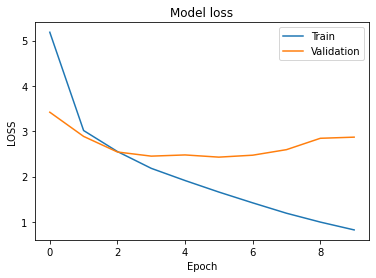

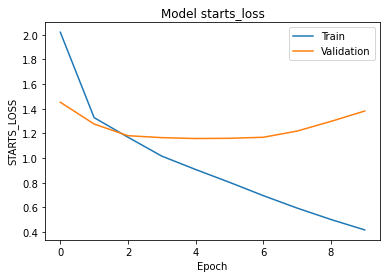

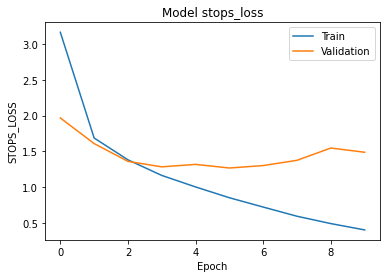

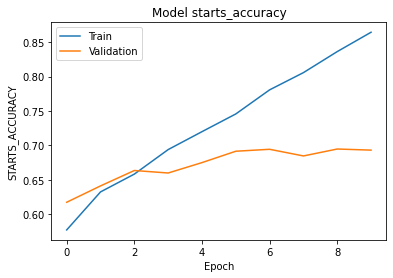

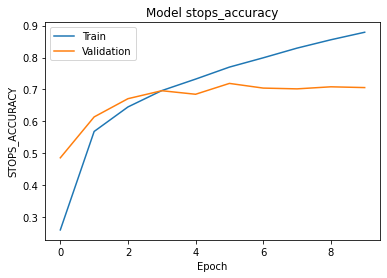

In [47]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss", "starts_accuracy", "stops_accuracy"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [ ]:
#model.save("../results/"+MODEL_PREFIX+"EndCheckpoint.h5")

In [ ]:
#from tensorflow.keras.models import load_model

#model = tf.keras.models.load_model(
#    filepath="../results/"+MODEL_PREFIX+"BestCheckpoint.h5",
#    compile=True
#)

In [48]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val, "token_ids": np.zeros_like(X_att_val)},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

4971/4971 [==============================] - 55s 11ms/sample - loss: 4.1376 - starts_loss: 2.1307 - stops_loss: 2.0090 - starts_accuracy: 0.7091 - stops_accuracy: 0.7206s - loss: 4.1410 - starts_loss: 2.1301 - stops_loss: 2.0109 - starts_accuracy: 0.7081 - stops_accur - ETA: 3s - loss: 4.1368 - starts_loss: 2.1253 - stops_loss: 2.0115 - starts_


[4.137583604216878, 2.130742, 2.008968, 0.7091129, 0.7205794]

In [54]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train, "token_ids": np.zeros_like(X_att_train)},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val, "token_ids": np.zeros_like(X_att_val)},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test, "token_ids": np.zeros_like(X_att_test)},
                          batch_size=PREDICT_BATCH_SIZE)

In [55]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [56]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(19885, 106) (19885, 106)
(4971, 106) (4971, 106)
(3534, 106) (3534, 106)


In [57]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [58]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

82.60 	|| train 	|| starts 	|| accuracy_score
83.82 	|| train 	|| stops 	|| accuracy_score
73.85 	|| valid 	|| starts 	|| accuracy_score
83.82 	|| valid 	|| stops 	|| accuracy_score
68.02 	|| train 	|| starts 	|| f1_score
84.51 	|| train 	|| stops 	|| f1_score
47.60 	|| valid 	|| starts 	|| f1_score
84.51 	|| valid 	|| stops 	|| f1_score
68.67 	|| train 	|| starts 	|| precision_score
84.67 	|| train 	|| stops 	|| precision_score
47.42 	|| valid 	|| starts 	|| precision_score
84.67 	|| valid 	|| stops 	|| precision_score
68.32 	|| train 	|| starts 	|| recall_score
85.03 	|| train 	|| stops 	|| recall_score
48.83 	|| valid 	|| starts 	|| recall_score
85.03 	|| valid 	|| stops 	|| recall_score
	|| train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V17_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V17_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V17_valid_starts.csv
	|| valid 	|| stops 

/home/deepaksadulla/.conda/envs/Dev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deepaksadulla/.conda/envs/Dev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Postprocessing

In [59]:
Y_words_train = [tokenizer.decode(i) for i in Y_train]
Y_words_val = [tokenizer.decode(i) for i in Y_val]

In [60]:
print(pred_starts_train.shape[0],
      sum([s<e for s,e in zip(pred_starts_train.argmax(axis=1),
                              pred_stops_train.argmax(axis=1))]))
print(pred_starts_val.shape[0],
      sum([s<e for s,e in zip(pred_starts_val.argmax(axis=1),
                              pred_stops_val.argmax(axis=1))]))
print(pred_starts_test.shape[0],
      sum([s<e for s,e in zip(pred_starts_test.argmax(axis=1),
                              pred_stops_test.argmax(axis=1))]))

19885 16309
4971 4081
3534 2895


In [61]:
def post_process(string):
    string = re.sub(pattern=" (negative|positive|neutral)[ ]+$", repl="", string=string)
    string = re.sub(pattern=" +", repl=" ", string=string.strip())
    return string

In [62]:
pred_words_train = [post_process(tokenizer.decode(t[s:e])) if s<e else post_process(tokenizer.decode(t[e:])) for t, s,e in zip(X_train, pred_starts_train.argmax(axis=1), pred_stops_train.argmax(axis=1))]
pred_words_val = [post_process(tokenizer.decode(t[s:e])) if s<e else post_process(tokenizer.decode(t[e:])) for t, s,e in zip(X_val, pred_starts_val.argmax(axis=1), pred_stops_val.argmax(axis=1))]
pred_words_test = [post_process(tokenizer.decode(t[s:e])) if s<e else post_process(tokenizer.decode(t[e:])) for t, s,e in zip(X_test, pred_starts_test.argmax(axis=1), pred_stops_test.argmax(axis=1))]

In [63]:
def jaccard(str1, str2):
    a = set(str1)
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [64]:
print("Training Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_train, pred_words_train)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i, str2=j) for i,j in zip(Y_words_val, pred_words_val)]))

Training Jaccard Score 0.7304299962002873
Validation Jaccard Score 0.7046837889658129


In [65]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

## Submission

In [66]:
test_df['selected_text'] = pred_words_test

In [67]:
test_df[["text", "sentiment","selected_text"]].head(15)

,text,sentiment,selected_text
0,Last session of the day http://twitpic.com/67ezh,neutral,last session of the
1,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,exciting (precisely -- skyscrapers galore). good tweeps in china: (sh) (bj).
2,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative,such a shame
3,happy bday!,positive,happy bday
4,http://twitpic.com/4w75p - I like it!!,positive,i like it
5,that`s great!! weee!! visitors!,positive,that`s great
6,I THINK EVERYONE HATES ME ON HERE lol,negative,hates me on here lol
7,"soooooo wish i could, but im in school and myspace is completely blocked",negative,blocked
8,and within a short time of the last clue all of them,neutral,and within a short time of the last clue all of
9,What did you get? My day is alright.. haven`t done anything yet. leaving soon to my stepsister though!,neutral,what did you get? my day is alright.. haven`t done anything yet. leaving soon to my stepsister though


In [68]:
test_df[["textID", "selected_text"]].to_csv("../results/submission_"+MODEL_PREFIX+".csv", index=False)

In [69]:
print(ctime(time()))

Tue May 12 08:37:39 2020
